## Use of Low-Cost Technology in Monitoring Household Air Pollution

This notebook describes the use of machine learing algorithms with 1% statistical significance to develop a callibration technique to measure household air pollution (HAP), as measured using particulate matter 2.5 (PM2.5) from sensor readings of humidity and temeperature. The approach will employ the model with the smallest MAE, MSE, and RMSE amongst: -
- Random forest regressor, 
- OLS regressor, 
- Naive bayes regressor, 
- Decision tree regressor, 
- Artificial neural network regressor,
- Gradient boosting regressor

Since the data is time-variant (time-series), repeated measures ANOVA will be used to pick the best sensor from among three (Plantower PMS 7003, Winsense ZH03, and Nova Fitness SDS011) by establishing one with the ability to detect smallest yet significant variations in indoor PM2.5. 

### 1) Loading Libraries, Setting Working Directory,  & Importing Data

In [223]:
# Load Libaries

import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, time, calendar
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from patsy import dmatrices
from scipy import stats
from scipy.stats import norm
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [224]:
pwd   #Check current WD

'D:\\EED\\Kaiote Water Metering'

In [3]:
# Change WD

import os 
os.chdir ("D:\EED\Kaiote Water Metering")  

In [4]:
pwd  # WD Changed

'D:\\EED\\Kaiote Water Metering'

In [383]:
# Load Data

Kibera = pd.read_excel("sample_data.xlsx", 
                       sheet_name = "Kibera",
                       usecols="B, H, I, K")

Kiambu = pd.read_excel("sample_data.xlsx", 
                       sheet_name = "Kiambu",
                       usecols="B, H, I, K")

### 2) Cleaning & Exploring Data

In [384]:
Kibera.head(5)

,Time,Humidity,Temperature,PM 2.5
0,1557223368,37.35,35.20,3
1,1557223423,36.74,34.97,2
2,1557223478,36.11,32.74,2
3,1557223532,35.75,32.47,1
4,1557223587,36.28,32.22,3


In [385]:
Kiambu.head(5)

,Time,Humidity,Temperature,PM 2.5
0,1556360723,32.11,37.40,1000
1,1556360773,32.48,37.76,1000
2,1556360823,32.28,37.41,1000
3,1556360873,32.81,35.22,1000
4,1556360923,32.85,35.00,1000


We shall proceed with `Kiambu` dataset for the rest of the analyses. 

In [386]:
Kiambu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 4 columns):
Time           3056 non-null int64
Humidity       3056 non-null float64
Temperature    3056 non-null float64
PM 2.5         3056 non-null int64
dtypes: float64(2), int64(2)
memory usage: 95.6 KB


In [387]:
Kiambu.shape  # Check number of observations and variables

(3056, 4)

In [388]:
print(type(Kiambu['Time']))    # Check class type
print(Kiambu['Time'].dtypes)   # Check variable type

<class 'pandas.core.series.Series'>
int64


In [389]:
Kiambu['Time'] = pd.to_datetime(Kiambu['Time'], unit='s')  # Convert UNIX time epoch to actual date

In [390]:
Kiambu.head(5)

,Time,Humidity,Temperature,PM 2.5
0,2019-04-27 10:25:23,32.11,37.40,1000
1,2019-04-27 10:26:13,32.48,37.76,1000
2,2019-04-27 10:27:03,32.28,37.41,1000
3,2019-04-27 10:27:53,32.81,35.22,1000
4,2019-04-27 10:28:43,32.85,35.00,1000


In [391]:
print(Kiambu['Humidity'].aggregate([min, max, sum]))    # Summary Statistics for Humidity
print(Kiambu['Humidity'].mean())
print(Kiambu['Temperature'].aggregate([min, max, sum])) # Summary Statistics for Temperature
print(Kiambu['Temperature'].mean())
print(Kiambu['PM 2.5'].aggregate([min, max, sum]))      # Summary Statistics for PM2.5
print(Kiambu['PM 2.5'].mean())


Kiambu.describe()

min        26.77
max        83.45
sum    168088.68
Name: Humidity, dtype: float64
55.00284031413619
min       16.73
max       37.76
sum    74776.89
Name: Temperature, dtype: float64
24.468877617801148
min         0
max      1000
sum    911859
Name: PM 2.5, dtype: int64
298.38318062827227


,Humidity,Temperature,PM 2.5
count,3056.000000,3056.000000,3056.000000
mean,55.002840,24.468878,298.383181
std,16.354156,6.059728,433.278098
min,26.770000,16.730000,0.000000
25%,39.820000,19.450000,5.000000
50%,55.745000,24.610000,14.000000
75%,70.890000,29.740000,1000.000000
max,83.450000,37.760000,1000.000000


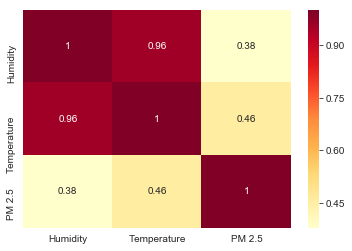

In [413]:
# Correlation Plot
sns.heatmap(abs(Kiambu.corr()), annot = True, cmap="YlOrRd")

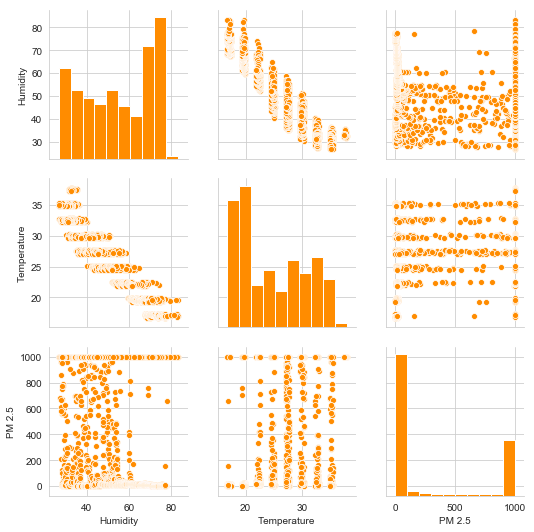

In [401]:
# Histograms

sns.set_style("whitegrid")
sns.color_palette("husl")
sns.set_palette(['darkorange']) 

sns.pairplot(Kiambu)

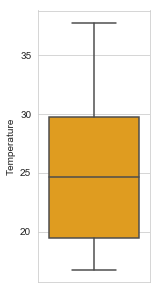

In [419]:
plt.figure(figsize = (2, 5)) # Define figure size
sns.boxplot(
    data = Kiambu,
    color = 'orange',
    #x = 'Time',          # Plotting boxplots against time slows down the machine
    y = 'Temperature')

# Multiple boxplots
#sns.boxplot(
#    x = 'Time',           # Plotting boxplots against time slows down the machine
#    y = 'value',
#    hue = 'variable',
#    data = pd.melt(Kiambu, 'Time'))

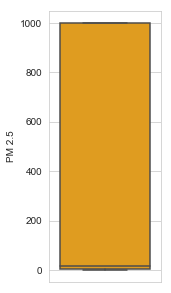

In [420]:
plt.figure(figsize = (2, 5)) # Define figure size
sns.boxplot(
    data = Kiambu,
    color = 'orange',
    #x = 'Time',          # Plotting boxplots against time slows down the machine
    y = 'PM 2.5')

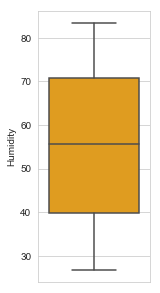

In [421]:
plt.figure(figsize = (2, 5)) # Define figure size
sns.boxplot(
    data = Kiambu,
    color = 'orange',
    #x = 'Time',          # Plotting boxplots against time slows down the machine
    y = 'Humidity')

Text(0.5, 1.0, 'Multiple Time Series Plots')

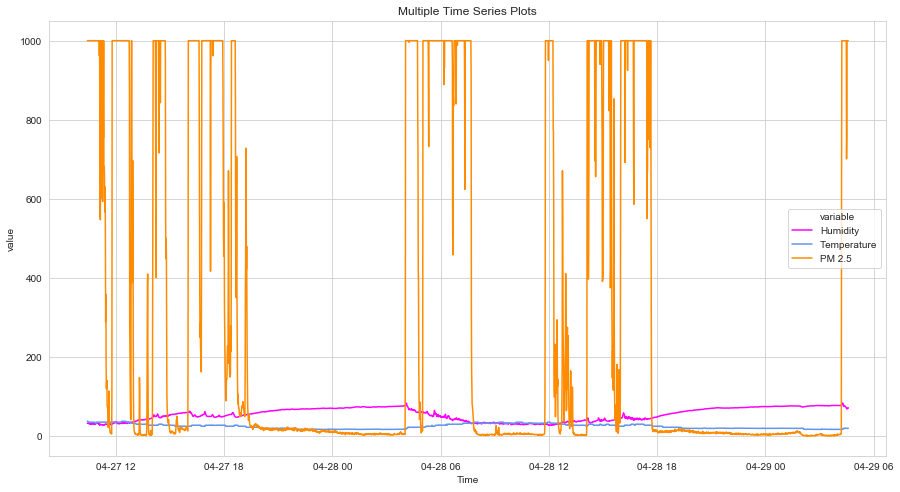

In [435]:
# Time Series Graphs
plt.figure(figsize=(15,8)) # Define plot size
sns.lineplot(x = 'Time', 
             y = 'value', 
             hue = 'variable', 
             palette = ('magenta', 'cornflowerblue', 'darkorange'),
             data = pd.melt(Kiambu, 'Time')) # Transfrom to long) for multiple lines
plt.title("Multiple Time Series Plots")

The multiple timeseries graphs above show extreme fluctuations in `PM 2.5` relative to `Humidity` and `Temperature`. Interestingly,  `PM 2.5` signal resembles a Fourier series on a square wave. In this regard, there is need to smoothen the series as shown in the next steps below using **long simple moving average** technique. In performing this procedure, we loose the square-wave property of `PM 2.5` and we reveal the sine-wave behaviour of `Humidity` and the cosine-wave element of `Temperature`, both indicative of strong, persistent seasonality underlyning the two variables which, in turn, are potential candidates for ARIMA time-series models when considered individually. This is shown in the following graphs.

In [264]:
# 1000-point Simple Moving Average to smooth the noisy signals. Also scale PM 2.5 down by 5/100
KiambuSmooth = Kiambu

KiambuSmooth['Humidity_SMA_1000'] = KiambuSmooth.iloc[:, 1].rolling(window = 1000).mean()
KiambuSmooth['Temperature_SMA_1000'] = KiambuSmooth.iloc[:, 2].rolling(window = 1000).mean()
KiambuSmooth['PM 2.5_SMA_1000'] = KiambuSmooth.iloc[:, 3].rolling(window = 1000).mean()*0.05

#KiambuSmooth['Humidity_ESA'] = KiambuSmooth.iloc[:, 1].ewm(span = 1000, adjust = False).mean()
#KiambuSmooth['Temperature_ESA'] = KiambuSmooth.iloc[:, 2].ewm(span = 1000, adjust = False).mean()
#KiambuSmooth['PM 2.5_ESA'] = KiambuSmooth.iloc[:, 3].ewm(span = 1000, adjust = False).mean()*0.05

In [265]:
KiambuSmooth.head(5)

,Time,Humidity,Temperature,PM 2.5,Humidity_SMA_1000,Temperature_SMA_1000,PM 2.5_SMA_1000
0,2019-04-27 10:25:23,32.11,37.40,1000,NaN,NaN,NaN
1,2019-04-27 10:26:13,32.48,37.76,1000,NaN,NaN,NaN
2,2019-04-27 10:27:03,32.28,37.41,1000,NaN,NaN,NaN
3,2019-04-27 10:27:53,32.81,35.22,1000,NaN,NaN,NaN
4,2019-04-27 10:28:43,32.85,35.00,1000,NaN,NaN,NaN


In [266]:
KiambuSmooth = KiambuSmooth.drop(['Humidity', 'Temperature', 'PM 2.5'], axis = 1) # axis = 1 means a column

Text(0.5, 1.0, 'Multiple Smoothed Time Series Plots')

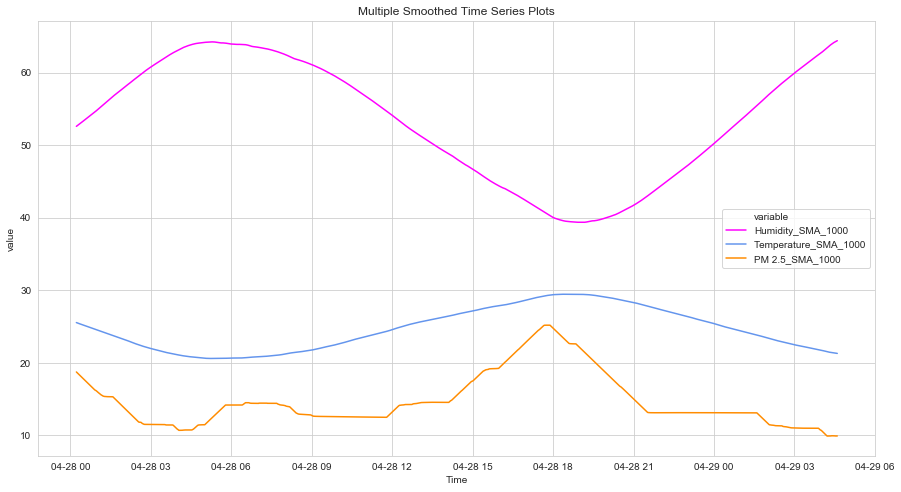

In [436]:
# Time Series Graphs
plt.figure(figsize=(15,8)) # Define plot size
sns.lineplot(x = 'Time', 
             y = 'value', 
             hue = 'variable', 
             palette = ('magenta', 'cornflowerblue', 'darkorange'),
             data = pd.melt(KiambuSmooth, 'Time')) # Transfrom to long) for multiple lines
plt.title("Multiple Smoothed Time Series Plots")

##### 2a) Exploring the Relationship Between Temperature and PM 2.5

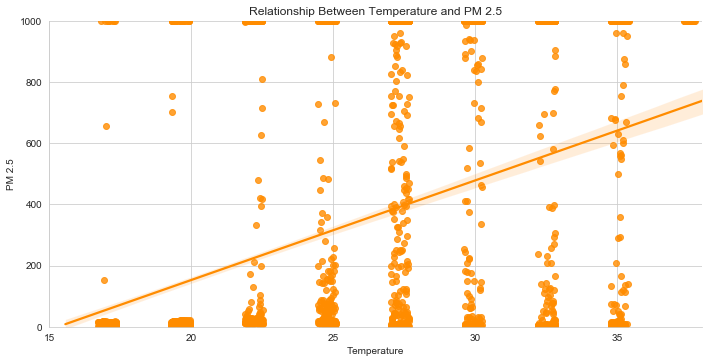

In [432]:
sns.set_style("whitegrid")
sns.color_palette("husl")
sns.set_palette(['darkorange']) 

g = sns.lmplot(x = "Temperature",
               y = "PM 2.5",
               data = Kiambu,
               aspect = 2)
g = (g.set_axis_labels("Temperature","PM 2.5").set(xlim = (15, 38), 
                                                   ylim = (0, 1000)))
plt.title("Relationship Between Temperature and PM 2.5")
plt.show(g)

In [269]:
# Simple Linear Regression

olsr_results = smf.ols(formula = "Kiambu['PM 2.5'] ~ Kiambu.Temperature", 
                       data = Kiambu, 
                       missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':1})

print(olsr_results.summary(alpha = 0.01))  # 99% CI

                            OLS Regression Results                            
Dep. Variable:       Kiambu['PM 2.5']   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     423.8
Date:                Sun, 02 Aug 2020   Prob (F-statistic):           2.78e-88
Time:                        21:05:03   Log-Likelihood:                -22535.
No. Observations:                3056   AIC:                         4.507e+04
Df Residuals:                    3054   BIC:                         4.509e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.005      0.995]
--------------------------------------------------------------------------------------
Intercept           -497.8737     33

The simple OLS regression above predicting `PM 2.5` using `Temperature` alone indicates that `20.7%` of the variation in `PM 2.5` can be expalined by `Temperature`. There is a postivie significant relationship between the two variables, as shown in the scatterplot preceeding the regression analysis.  Further, `Temperature` is a significant prdictor of at 99% level of confidence, as `PM 2.5` shown by a p-value of <0.0001. 

A unit increase in `Temperature` leads to an increase in `PM 2.5` by significant `32.5416`. The Durbin-Watson value of `0.04` indicates a positive autocorrelation pointing back to the time-series nature of the dataset. However, normality test of residuals using Jarque-Bera indicates that `Temperature` is not normally distributed, thus violating the normality assumption for the applicability OLS. Although this is a strong reason to transform the data (`PM 2.5`) first before fitting the linear model, the ANOVA p-value of `<0.0001` indicates that the model can reliably be used for predictions with 1% level of significance. 

The predition equation $\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x$ where $ \hat{y} $ is `PM 2.5` and $ x $ is `Temperature` becomes $\hat{y} = -497.8737 + 32.5416 x$.

##### 2b) Exploring the Relationship Between Humidity and PM 2.5

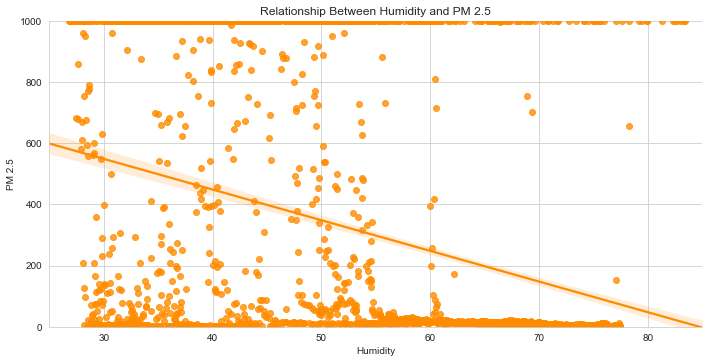

In [433]:
sns.set_style("whitegrid")
sns.color_palette("husl")
sns.set_palette(['darkorange']) 

g = sns.lmplot(x = "Humidity",
               y = "PM 2.5",
               data = Kiambu,
               aspect = 2)
g = g.set_axis_labels("Humidity","PM 2.5").set(xlim = (25, 85), ylim = (0, 1000))
plt.title("Relationship Between Humidity and PM 2.5")
plt.show(g)

In [271]:
# Simple Linear Regression

olsr_results = smf.ols(formula = "Kiambu['PM 2.5'] ~ Kiambu.Humidity", 
                       data = Kiambu, 
                       missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':1})

print(olsr_results.summary(alpha=0.01)) # 99% CI

                            OLS Regression Results                            
Dep. Variable:       Kiambu['PM 2.5']   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     271.6
Date:                Sun, 02 Aug 2020   Prob (F-statistic):           1.57e-58
Time:                        21:05:05   Log-Likelihood:                -22654.
No. Observations:                3056   AIC:                         4.531e+04
Df Residuals:                    3054   BIC:                         4.532e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.005      0.995]
-----------------------------------------------------------------------------------
Intercept         849.7318     39.569     

The OLS regression above shows a significant negative relationship between `PM 2.5` and `Humidity` at 99% level of confidence.A unit increase in humidity leads to a significant drop of `PM 2.5` by `10.024`. Moreover,  `Humidity` is a significant predictor of `PM 2.5` as inicated by the `z-score` p-value of `<0.00001`, and is responsible for `14.3%` of the variation in `PM 2.5`,  which is a small cause but the model is significant nonetheless, as indicated by ANOVA p-value of `<0.0001`. 

This means that the model can relibly be used for predicting `PM 2.5` at 1% level of significance. Jarque Bera test shows that the model residuals are significantly non-normal, and therefore the need to map `PM 2.5`to a Gaussian distrubtion becase `PM 2.5` evidently does not come from a normal distribution. 

The predition equation $\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x$ where $ \hat{y} $ is `PM 2.5` and $ x $ is `Humidity` becomes $\hat{y} = 849.7318 - 10.0240 x$.

In [272]:
# Multiple Linear Regression

olsr_results = smf.ols(formula = "Kiambu['PM 2.5'] ~ Kiambu.Temperature + Kiambu.Humidity", 
                       data = Kiambu, 
                       missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':1})

print(olsr_results.summary(alpha=0.01)) # 99% CI

                            OLS Regression Results                            
Dep. Variable:       Kiambu['PM 2.5']   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     297.3
Date:                Sun, 02 Aug 2020   Prob (F-statistic):          1.03e-118
Time:                        21:05:07   Log-Likelihood:                -22456.
No. Observations:                3056   AIC:                         4.492e+04
Df Residuals:                    3053   BIC:                         4.494e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.005      0.995]
--------------------------------------------------------------------------------------
Intercept          -2676.6779    229

We find from the above analysis that the multiple regression the equation $\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2$ where $ \hat{y} $ is `PM 2.5`, $ x_1 $ is `Temperature` and  $ x_2 $ is `Humidity` effectively becomes $\hat{y} = -2676.6779 + 80.1675 x_1 + 18.4254 x_2$

### 3) Modelling

For all the next modelling tasks, the training set is 70% while the validatuion set is 30% of the records of `Kiambu` datset. Most modelling tasks will use `sklearn` module and not `statsmodels`module.

In [273]:
# We prepare the datset as follows.

X = Kiambu[['Humidity', 'Temperature']]  # Separate the features
y = Kiambu['PM 2.5']                     # Separate the outcome

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size = 0.3, random_state = 50)  # Set seed as 50 to reproduce the random samples

###### 3 (i) a) OLS Regressor - Training

In [274]:
OLS_regressor = LinearRegression(fit_intercept = True, 
                                 normalize = True).fit(X_train, y_train) # Normalize to correct for non-gaussian residuals

Check coefficient of determnation of the model $(R^2)$ which tells us the amount of variation in `PM 2.5` caused by both `Temperature` and `Humidity`. This is done as below.

In [277]:
r_sq = OLS_regressor.score(X_test, y_test)
print('The coefficient of determination is', round(r_sq, 5), \
      ', which means', round(r_sq, 5)*100,\
      '% of the variation in PM 2.5 is attributable to both humidity and temperature.')

The coefficient of determination is 0.28575 , which means 28.575 % of the variation in PM 2.5 is attributable to both humidity and temperature.


We obatin the regression intercept and coefficinets as follows.

In [278]:
print('intercept:', OLS_regressor.intercept_)

#print('coefficients:', OLS_regressor.coef_)

coeffs = pd.DataFrame(OLS_regressor.coef_, X.columns, columns=['Coefficient'])
coeffs

intercept: -2659.12738521879


,Coefficient
Humidity,18.617290
Temperature,78.668408


###### 3 (i) b) OLS Regressor - Validation

In [291]:
y_pred = OLS_regressor.predict(X_test)
Kiambu_Test_Pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
Kiambu_Test_Pred.head(5)

,Actual,Predicted
2052,1000,304.024679
2998,1,101.017863
3032,1000,235.781808
1210,4,55.945818
1182,4,31.449394


In [287]:
Kiambu_Test_Pred.describe()

,Actual,Predicted
count,917.000000,917.000000
mean,317.742639,289.151897
std,441.173882,204.935568
min,0.000000,-67.222241
25%,5.000000,110.529440
50%,15.000000,253.264930
75%,1000.000000,447.826370
max,1000.000000,922.429367


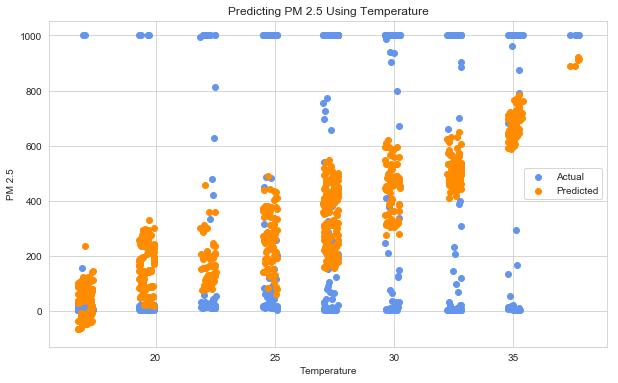

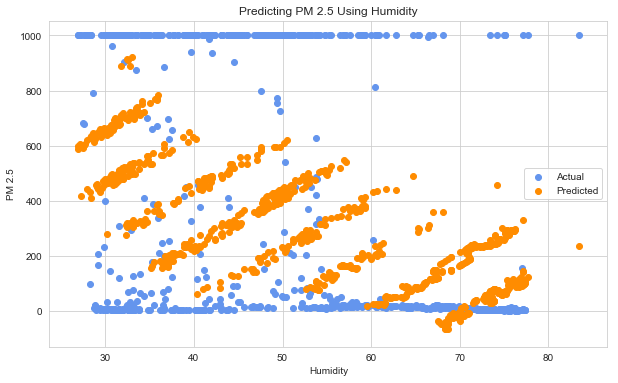

In [376]:
plt.figure(figsize=(10,6)) # Define plot size
plt.scatter(X_test.Temperature, y_test, color ='cornflowerblue', label = 'Actual') 
plt.scatter(X_test.Temperature, y_pred, color ='darkorange', label = 'Predicted') 
plt.title('Predicting PM 2.5 Using Temperature')
plt.xlabel('Temperature')
plt.ylabel('PM 2.5')
plt.legend(loc='center right')
plt.show()

plt.figure(figsize=(10,6)) # Define plot size
plt.scatter(X_test.Humidity, y_test, color ='cornflowerblue', label = 'Actual') 
plt.scatter(X_test.Humidity, y_pred, color ='darkorange', label = 'Predicted')
plt.title('Predicting PM 2.5 Using Humidity')
plt.xlabel('Humidity')
plt.ylabel('PM 2.5')
plt.legend(loc = 'center right')
plt.show()

Test model goodness of fit using MAE, MSE and RMSE. We shall finally pick the model with the smallest MAE from the several models that we are going to build in the next sections.

In [283]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))

print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))

print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error (MAE): 296.33156385546704
Mean Squared Error (MSE): 138865.79158728913
Root Mean Squared Error (RMSE): 372.64700667963126


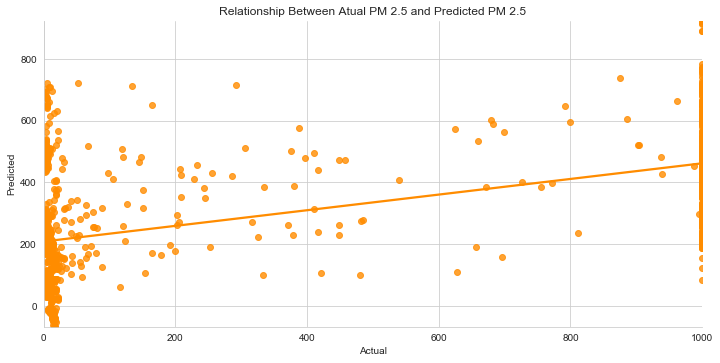

In [434]:
sns.set_style("whitegrid")
sns.color_palette("husl")
sns.set_palette(['darkorange']) 

g = sns.lmplot(x = "Actual",
               y = "Predicted",
               ci = True,
               data = Kiambu_Test_Pred,
               aspect = 2)
g = (g.set_axis_labels("Actual","Predicted").set(xlim = (0, 1000), 
                                                   ylim = (-67.222241, 922.429367)))
plt.title("Relationship Between Atual PM 2.5 and Predicted PM 2.5")
plt.show(g)

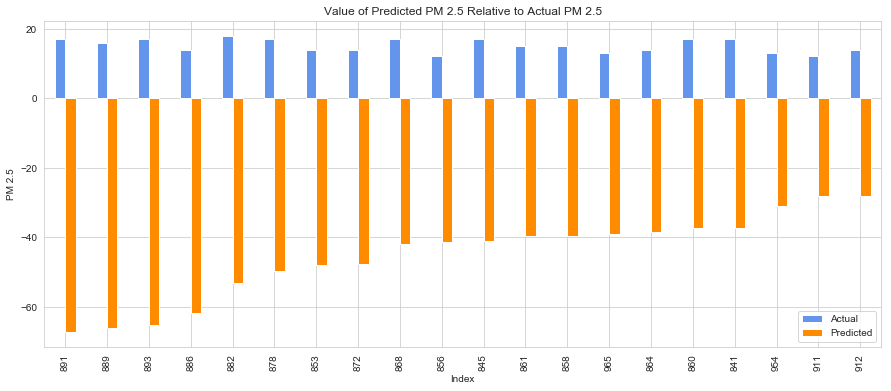

In [375]:
Kiambu_Test_Pred_Few = Kiambu_Test_Pred.sort_values(by=['Predicted']).head(20)
Kiambu_Test_Pred_Few.plot(kind = 'bar', 
                          figsize = (15, 6), 
                          color = ("cornflowerblue", "darkorange"))
plt.title('Value of Predicted PM 2.5 Relative to Actual PM 2.5')
plt.xlabel('Index')
plt.ylabel('PM 2.5')
plt.show()

###### 3 (ii) a) Random Forest Regressor - Validation